# Predicting dispersion coefficient


This example will show how to find the dispersion coefficient of a porous medium. The following equation given by Fried (1971) is used to solve the longitudinal dispersion coefficient:

$$\frac{C}{C_{0}} = \frac{1}{2}erfc\Bigl(\frac{x-Ut}{2(D_{L}t)^{\frac{1}{2}}}\Bigr)+\frac{1}{2}exp\Bigl(\frac{Ux}{D_{L}}\Bigl)erfc\Bigr(\frac{x+Ut}{2(D_{L}t)^{\frac{1}{2}}}\Bigr)$$

Where $x$ is the length between the inlet and the outlet, $t$ is the time, $D_{L}$ is the longitudinal dispersion coefficient, $U$ is the average pore velocity, $C_{0}$ is the inlet concentration, and $C$ is the concentration at the given time. $erfc$ is the complementary error function. In this example we implement a transient advection diffusion algorithm to fit the data to the equation above and find the value of $D_{L}$. 

In [1]:
import numpy as np
import openpnm as op
from scipy import special
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

## Generating Network and phase
First, we create a network and assign the phase and properties in a similar way that we used to do for the other examples. A 2D ``Cubic`` network is generated here, but a 3D network would work as well. Note that `op.models.collections.phase` is added to assign fluid properties such as viscosity, etc, and `op.models.collections.physics` is added to assign pore-scale models such as entry pressure, conduit conductance. A user-defined value for water diffusivity was assumed, as it is not included in `collections.phase.water`.

In [2]:
shape = [40, 40, 1]
pn = op.network.Cubic(shape=shape, spacing=1e-4)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
water = op.phase.Water(network=pn)
water['pore.diffusivity'] = 1e-9
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.standard)
water.regenerate_models()

------------------------------------------------------------
  - ERROR  : throat.electrical_conductance was not run since the following property is missing:
             'throat.electrical_conductivity' 
  - SOURCE : openpnm.core._base2.regenerate_models 
  - TIME   : 2022-09-02 10:35:50,930    
------------------------------------------------------------


## Defining Effective Pore Volume

The accumulation of mass in the network occurs only in the pores, where the concentration is solved.  In order for mass  accumulate properly, it is necessary to assign the throat volumes to their surrounded throats.  This creates an effective pore volume.  We can define this in a custom pore-scale model, making use of the ``numpy.add.at`` function, to add 1/2 the volume of each throat to its neighboring pores.  

In [3]:
def effective_pore_volume(target, throat_volume='throat.volume', pore_volume='pore.volume'):
    Pvol = pn['pore.volume']
    Tvol = pn['throat.volume']
    Vtot = Pvol.sum() + Tvol.sum()
    np.add.at(Pvol, pn.conns[:, 0], pn['throat.volume']/2)
    np.add.at(Pvol, pn.conns[:, 1], pn['throat.volume']/2)
    assert np.isclose(Pvol.sum(), Vtot)  # Ensure total volume has been added to Pvol
    return Pvol

In [4]:
pn.add_model(propname='pore.effective_volume', model=effective_pore_volume)

## Perform Stokes flow
The advection diffusion algorithm assumes a velocity field. Therefore, Stokes flow in the pore netwok is solved prior to running the ``AdvectionDiffusion`` algorthim. Note that we updated the phase property after based on pressure distribution from stokes flow results:

In [5]:
sf = op.algorithms.StokesFlow(network=pn, phase=water)
sf.set_value_BC(pores=pn.pores('back'), values=50.0)
sf.set_value_BC(pores=pn.pores('front'), values=0)
sf.run();
water.update({'pore.pressure':sf['pore.pressure']})

## Apply transient advection diffusion
An algorthim for transient advection diffusion is defined here for a range of timesteps. We must also tell the algorithm to use the effective pore volume rather than the default which is just `pore.volume`. Here, the solution is saved at intervals of 5 through the integration time span `tspan`. 

In [6]:
mod = op.models.physics.ad_dif_conductance.ad_dif
water.add_model(propname='throat.ad_dif_conductance', model=mod, s_scheme='powerlaw')
ad = op.algorithms.TransientAdvectionDiffusion(network=pn, phase=water)
ad.settings._update({'pore.volume' : 'pore.effective_volume'})
inlet  = pn.pores('back') 
outlet = pn.pores('front')
ad.set_value_BC(pores=inlet, values=1.0)
ad.set_outflow_BC(pores=outlet)
tspan = (0, 100)
saveat = 5
soln = ad.run(x0=0, tspan=tspan, saveat=saveat)

## Elution curve

To plot the elution curve from simulation data, we calculate the average concentration at each time step in the `soln` as follows:

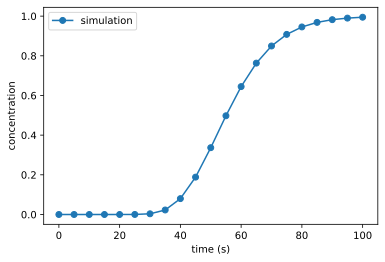

In [7]:
Ps_front = pn.pores(['front'])
Ts_front = pn.find_neighbor_throats(pores=Ps_front, mode='xor')
steps = tspan[1]/saveat + 1
count = 0
c_avg = []

for ti in soln['pore.concentration'].t:
    c_front = soln['pore.concentration'](ti)[Ps_front]
    q_front = sf.rate(throats=pn.Ts,mode='single')[Ts_front]
    c_avg.append((q_front*c_front).sum() / q_front.sum())

fig, ax = plt.subplots()    
ax.plot(soln['pore.concentration'].t, c_avg, "o-")
ax.legend(('simulation', 'fitted'))
ax.set_xlabel('time (s)')
ax.set_ylabel('concentration');

## Solving for the dispersion coefficient

Since we will define the inlet concentration as being equal to 1, solving for $C$ is effictivly equal to solving for $\frac{C}{C_{0}}$.

We create a function for elution for curve fitting of solution data to the function. The known values are time and concentration found from the transport solution. From curve fittiong, the values of $D_{L}$ and $U$ will be found. 

In [8]:
def elution(step,v,DL):
    x = 40*1e-4
    el1 = 0.5*(special.erfc((x-step*v)/(2*(DL*step)**(1/2))))
    el2 = 0.5*np.exp(v*x/DL)
    el3 = special.erfc((x+step*v)/(2*(DL*step)**(1/2)))
    return el1+el2*el3

Here we calculate the average velocity (v_pred) to compare with the value found from curve fitting.

In [9]:
q_throat = sf.rate(throats=pn.Ts, mode='single')
A_throat = pn['throat.cross_sectional_area']
v_throat = q_throat/A_throat
v_pred = sum(q_throat*v_throat)/sum(q_throat)

g = [v_pred, 1e-3]
xdata = [float(x) for x in soln['pore.concentration'].t]
ydata = c_avg

Let's apply a curve fitting to concentration vs time data:

In [10]:
popt, pcov = curve_fit(elution, xdata, ydata, p0=g)
disp_coeff = popt[1]
v_fit = popt[0]

print('Dispersion Coefficient = ', "{0:.4E}".format(disp_coeff), ' m^2/s')
print('v_pred = ', "{0:.4E}".format(v_pred), ' m/s')
print('v_fitted = ', "{0:.4E}".format(v_fit), ' m/s')

Dispersion Coefficient =  7.6581E-09  m^2/s
v_pred =  2.3610E-04  m/s
v_fitted =  7.0669E-05  m/s


Now we can visualize the fitted curve and original data from simulation. The values of concentration vs time from fitted curve and the values from simulation:

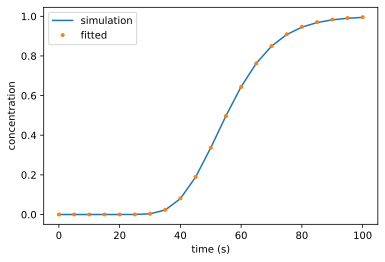

In [11]:
el = np.zeros(len(ydata))
for i in range(len(ydata)):
    el[i] = elution(xdata[i], popt[0], popt[1])

fig, ax = plt.subplots()
ax.plot(xdata, ydata, label="simulation")
ax.plot(xdata, el, ".", label="fitted")
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('concentration');